In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/plantclef-2025/pseudoquadrats_without_labels_complementary_training_set_urls.csv
/kaggle/input/plantclef-2025/PlantCLEF2024_single_plant_training_metadata.csv
/kaggle/input/plantclef-2025/species_ids.csv
/kaggle/input/plantclef-2025/PlantCLEF2025_test.csv
/kaggle/input/plantclef-2025/PlantCLEF2025_test_images/PlantCLEF2025_test_images/CBN-PdlC-F6-20200812.jpg
/kaggle/input/plantclef-2025/PlantCLEF2025_test_images/PlantCLEF2025_test_images/CBN-PdlC-A4-20190722.jpg
/kaggle/input/plantclef-2025/PlantCLEF2025_test_images/PlantCLEF2025_test_images/CBN-Pla-C3-20160728.jpg
/kaggle/input/plantclef-2025/PlantCLEF2025_test_images/PlantCLEF2025_test_images/CBN-Pla-C3-20160707.jpg
/kaggle/input/plantclef-2025/PlantCLEF2025_test_images/PlantCLEF2025_test_images/CBN-PdlC-E1-20180815.jpg
/kaggle/input/plantclef-2025/PlantCLEF2025_test_images/PlantCLEF2025_test_images/LISAH-BVD-0-283-20230516.jpg
/kaggle/input/plantclef-2025/PlantCLEF2025_test_images/PlantCLEF2025_test_images/RNNB-5-1-20

In [1]:
import numpy as np 
import pandas as pd
import timm 
import torch
from PIL import Image
from torch.utils.data import DataLoader, Dataset
import time
import os
import torchvision.transforms as T
from torch.amp import autocast
from matplotlib import pyplot as plt
from kornia import tensor_to_image
from kornia.contrib import extract_tensor_patches, compute_padding
import csv

In [2]:
df_species_ids = pd.read_csv('/kaggle/input/plantclef-2025/species_ids.csv')

df_metadata = pd.read_csv('/kaggle/input/plantclef-2025/PlantCLEF2024_single_plant_training_metadata.csv', sep=';', dtype={'partner': str})
class_map = df_species_ids['species_id'].to_dict() # dictionary to map the species model Id with the species Id

df_metadata.head()

,image_name,organ,species_id,obs_id,license,partner,author,altitude,latitude,longitude,gbif_species_id,species,genus,family,dataset,publisher,references,url,learn_tag,image_backup_url
0,59feabe1c98f06e7f819f73c8246bd8f1a89556b.jpg,leaf,1396710,1008726402,cc-by-sa,NaN,Gulyás Bálint,205.9261,47.592160,19.362895,5284517.0,Taxus baccata L.,Taxus,Taxaceae,plantnet,plantnet,https://identify.plantnet.org/fr/k-southwester...,https://bs.plantnet.org/image/o/59feabe1c98f06...,train,https://lab.plantnet.org/LifeCLEF/PlantCLEF202...
1,dc273995a89827437d447f29a52ccac86f65476e.jpg,leaf,1396710,1008724195,cc-by-sa,NaN,vadim sigaud,323.7520,47.906703,7.201746,5284517.0,Taxus baccata L.,Taxus,Taxaceae,plantnet,plantnet,https://identify.plantnet.org/fr/k-southwester...,https://bs.plantnet.org/image/o/dc273995a89827...,train,https://lab.plantnet.org/LifeCLEF/PlantCLEF202...
2,416235e7023a4bd1513edf036b6097efc693a304.jpg,leaf,1396710,1008721908,cc-by-sa,NaN,fil escande,101.3160,48.826774,2.352774,5284517.0,Taxus baccata L.,Taxus,Taxaceae,plantnet,plantnet,https://identify.plantnet.org/fr/k-southwester...,https://bs.plantnet.org/image/o/416235e7023a4b...,train,https://lab.plantnet.org/LifeCLEF/PlantCLEF202...
3,cbd18fade82c46a5c725f1f3d982174895158afc.jpg,leaf,1396710,1008699177,cc-by-sa,NaN,Desiree Verver,5.1070,52.190427,6.009677,5284517.0,Taxus baccata L.,Taxus,Taxaceae,plantnet,plantnet,https://identify.plantnet.org/fr/k-southwester...,https://bs.plantnet.org/image/o/cbd18fade82c46...,train,https://lab.plantnet.org/LifeCLEF/PlantCLEF202...
4,f82c8c6d570287ebed8407cefcfcb2a51eaaf56e.jpg,leaf,1396710,1008683100,cc-by-sa,NaN,branebrane,165.3390,45.794739,15.965862,5284517.0,Taxus baccata L.,Taxus,Taxaceae,plantnet,plantnet,https://identify.plantnet.org/fr/k-southwester...,https://bs.plantnet.org/image/o/f82c8c6d570287...,train,https://lab.plantnet.org/LifeCLEF/PlantCLEF202...


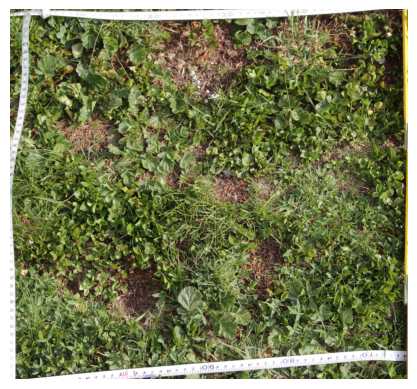

In [18]:
#img = Image.open('/kaggle/input/plantclef-2025/PlantCLEF2025_test_images/PlantCLEF2025_test_images/GUARDEN-CBNMed-30-4-16-3-20240428.jpg')
img = Image.open('/kaggle/input/plantclef-2025/PlantCLEF2025_test_images/PlantCLEF2025_test_images/CBN-PdlC-E5-20190722.jpg')
plt.imshow(img)
plt.axis('off')
plt.show()

In [20]:
patch_size = 518
stride = int(518/ 2)


image_to_tensor = T.ToTensor()

image_tensor = image_to_tensor(img).unsqueeze(0)
h, w = image_tensor.shape[-2:]

pad = compute_padding(original_size=(h, w), window_size=patch_size, stride=stride)

patches = extract_tensor_patches(image_tensor, patch_size, stride, padding=pad)
print(f"Shape of image tiles = {patches.shape}")

Shape of image tiles = torch.Size([1, 121, 3, 518, 518])


IndexError: index 64 is out of bounds for axis 0 with size 64

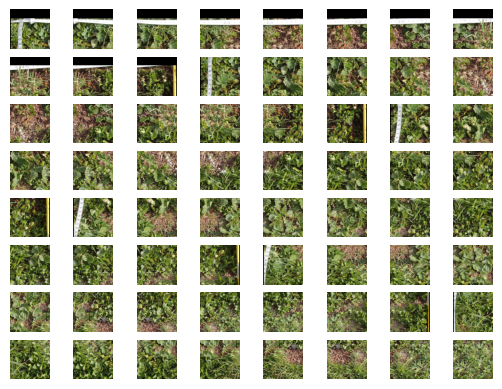

In [21]:
fig, axs = plt.subplots(8, 8)
axs = axs.ravel()

for i in range(len(patches[0])):
    axs[i].axis("off")
    axs[i].imshow(tensor_to_image(patches[0][i]))

plt.show()